## Test a 2D Gyro GP relation in PyStan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan

In [2]:
angus = [0.40, 0.31, 0.45, 0.55] 

def gyro(tau, bv, a, b, c, d):
    return tau*1000**d * a*(bv - c)**b

For now we'll assume that BPRP and Age have no uncertainty. We'll add the uncertainty on those later with a latent implementation.

$P = \tau^d \times a(B - V - c)^b$

where $P$ is rotation in days
$\tau$ is age (in Myr),
B-V are colour in magnitude,
the rest are free parameters


In [3]:
npts = 25
bprp_true = np.sort(np.random.randn(npts) * 0.2 + 0.9)
age_true = np.sort(10**(np.random.uniform(0.3, 0.9, npts)))

period_true = gyro(age_true, bprp_true, *angus)

sigma_p = bprp_true * 8.
period_obs = period_true + np.random.randn(npts) * sigma_p

Npred = 500
bprpf = np.linspace(bprp_true.min(), bprp_true.max(), Npred)
agef = np.linspace(age_true.min(), age_true.max(), Npred)

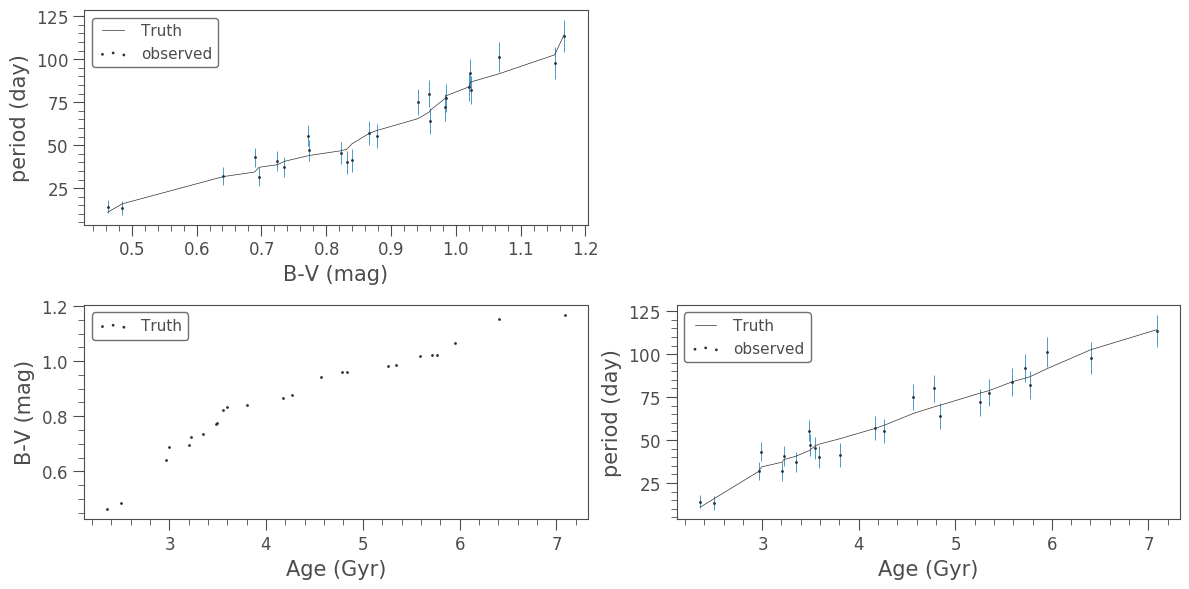

In [4]:
import matplotlib.gridspec as gridspec
import mystyle as ms

with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.plot(bprp_true, period_true, label='Truth')
    ax0.scatter(bprp_true, period_obs,zorder=1, label='observed')
    ax0.errorbar(bprp_true, period_obs, yerr=sigma_p, fmt='|',zorder=0)
    ax0.set_xlabel('B-V (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.plot(age_true, period_true, label='Truth')
    ax1.scatter(age_true, period_obs,zorder=1, label='observed')
    ax1.errorbar(age_true, period_obs, yerr=sigma_p, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_true, bprp_true, label='Truth')
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('B-V (mag)')
    ax2.legend()    
    
    fig.tight_layout()
    plt.show()

In [6]:
gpfit = '''
functions {
    matrix multi_cov_exp_quad(real[] x, real alpha_x, real rho_x, real[] y, real alpha_y, real rho_y){
        return exp(log(cov_exp_quad(x, alpha_x, rho_x)) + 
                    log(cov_exp_quad(y, alpha_y, rho_y)));
    }
} 
data {
    int<lower=1> N;
    
    real bprp[N];
    real age[N];
    
    vector[N] P;
    real sigma_p[N];
    
    int<lower=1> Npred;
    real bprpf[Npred];
    real agef[Npred];
}
transformed data{
    real delta = 1e-9;
}
parameters {
    real<lower=0> alpha[2];
    real<lower=0> rho[2];
    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> c;
    real<lower=0> d;
    vector[N] eta;
}
transformed parameters{
    vector[N] f;
    {
        vector[N] mu;
        matrix[N, N] K;
        matrix[N, N] L_K;
        
        K = multi_cov_exp_quad(bprp, alpha[1], rho[1], age, alpha[2], rho[2]);
        
        // diagonal elements
        for (n in 1:N){
            K[n, n] = K[n, n] + delta;        
            mu[n] = (age[n]*1000)^d * a *(bprp[n] - c)^b;
        }
        
        L_K = cholesky_decompose(K);
        f = mu + L_K * eta;
    }
}
model {
    rho ~ lognormal(1, 1);
    alpha ~ std_normal();
    eta ~ std_normal();
    
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    c ~ normal(0., 1.);
    d ~ normal(0., 1.);
    
    P ~ normal(f, sigma_p);
}
generated quantities {
    vector[Npred] Ppred;
    {
        vector[Npred] mupred;
        matrix[Npred, Npred] Kpred;
        matrix[Npred, Npred] L_Kpred;
        
        Kpred = multi_cov_exp_quad(bprpf, alpha[1], rho[1], agef, alpha[2], rho[2]);
        
        // diagonal elements
        for (n in 1:Npred){
            Kpred[n, n] = Kpred[n, n] + delta;        
            mupred[n] = (agef[n]*1000)^d * a *(bprpf[n] - c)^b;
        }
        
        L_Kpred = cholesky_decompose(Kpred);
        Ppred = multi_normal_cholesky_rng(mupred, L_Kpred);
    }
}
'''
sm = pystan.StanModel(model_code = gpfit, model_name='gpfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gpfit_3c8f1dd2cdd51b2d727a25896dac816b NOW.


In [7]:
data = {'N' : len(bprp_true),
       'P' : period_obs,
       'sigma_p' : sigma_p,
       'bprp' : bprp_true,
       'age' : age_true,
       'Npred' : Npred,
       'agef' : agef,
       'bprpf' : bprpf}
        
init = {'alpha' : [0.4, 0.4],
        'rho' : [1., 1,],
         'a' : angus[0],
         'b' : angus[1],
         'c' : angus[2],
         'd' : angus[3],
         'f' : period_true}

In [8]:
fit = sm.sampling(data=data, iter=5000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [9]:
print(fit)

Inference for Stan model: gpfit_3c8f1dd2cdd51b2d727a25896dac816b.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]     0.79  5.6e-3    0.6   0.03   0.32   0.67   1.13   2.23  11428    1.0
alpha[2]     0.79  5.6e-3    0.6   0.03   0.32   0.66   1.13   2.26  11396    1.0
rho[1]       4.46    0.06   5.77    0.4   1.39   2.72   5.31   19.2   7979    1.0
rho[2]       4.47    0.06   5.55   0.41   1.41   2.76   5.45  18.62   8207    1.0
a             0.8  6.5e-3   0.57   0.07   0.36   0.69   1.13   2.18   7702    1.0
b            0.94  4.2e-3   0.26   0.48   0.74   0.91   1.12    1.5   4024    1.0
c            0.25  1.8e-3   0.11   0.02   0.17   0.27   0.34   0.43   3961    1.0
d             0.6  1.6e-3    0.1   0.45   0.53   0.58   0.66   0.85   4304    1.0
eta[1]      -0.02  8.2e-3    1.0  -1.99  -0.69  -0.01   0.66   1.93  14816   

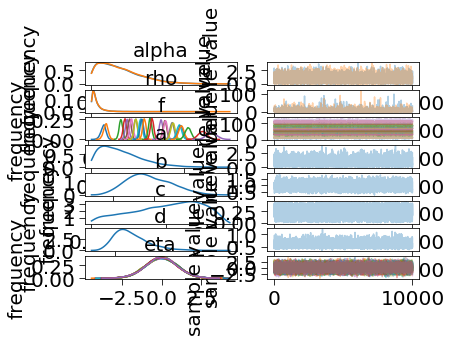

In [13]:
fit.plot(pars=['alpha','rho','f','a','b','c','d','eta'])
plt.show()

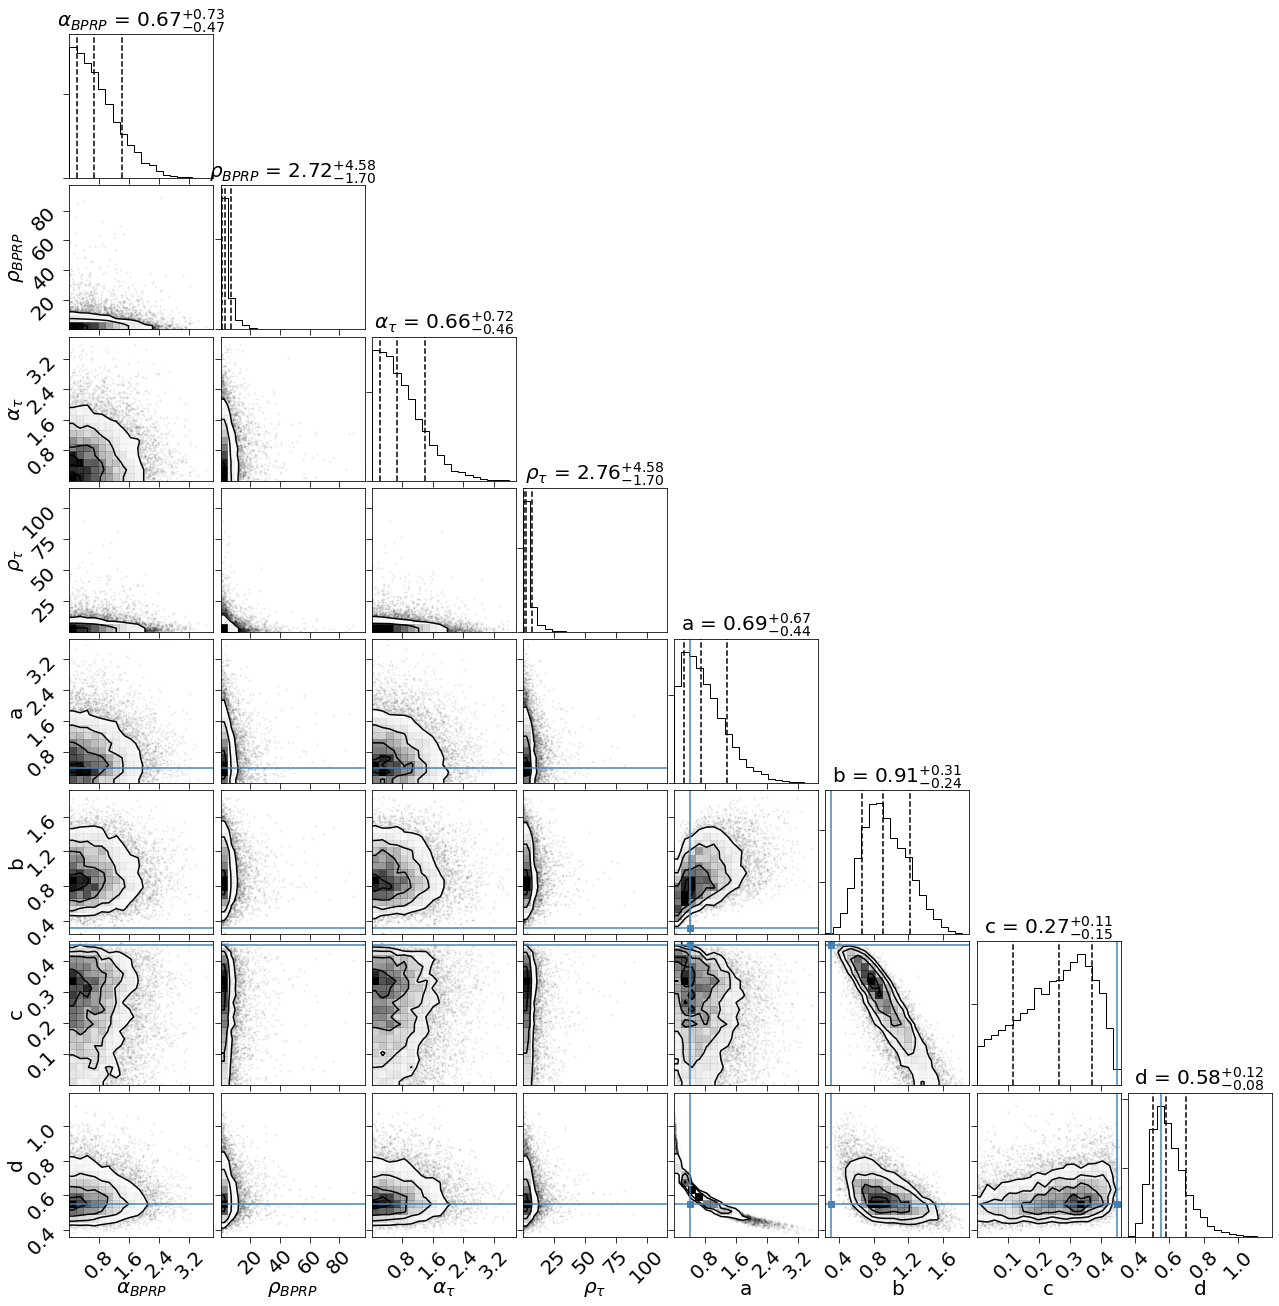

In [14]:
import corner
j = np.array([fit['alpha'].T[0], fit['rho'].T[0], fit['alpha'].T[1], fit['rho'].T[1]])
k = np.array([fit[label] for label in ['a','b','c','d']])
chain = np.concatenate((j,k))
truths = [np.nan, np.nan, np.nan, np.nan, *angus]

verbose= [r'$\alpha_{BPRP}$',r'$\rho_{BPRP}$',r'$\alpha_\tau$',r'$\rho_\tau$','a','b','c','d']
corner.corner(chain.T, labels=verbose,truths=truths,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

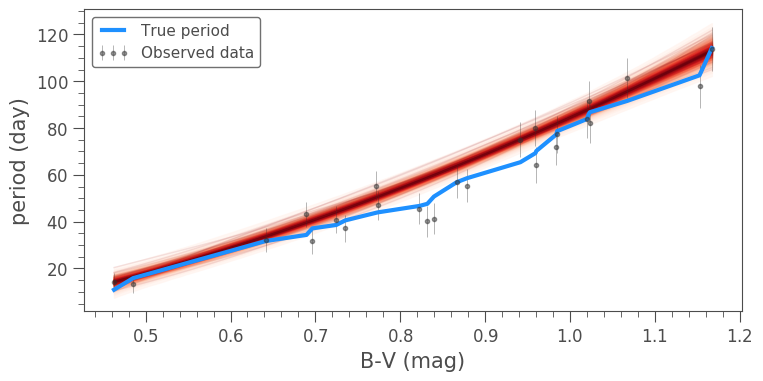

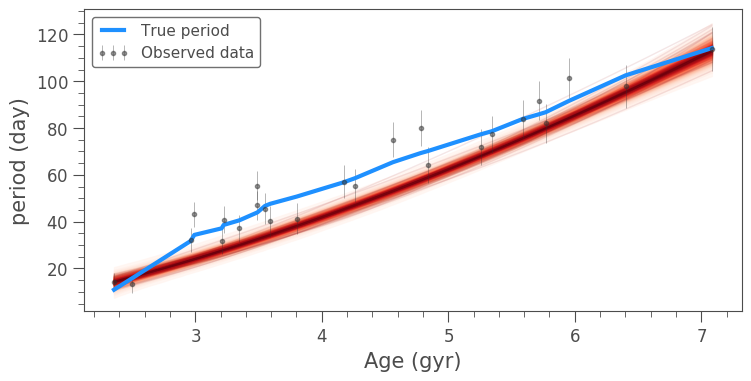

In [15]:
from pymc3.gp.util import plot_gp_dist


with plt.style.context(ms.ms):
    fig = plt.figure()
    ax = fig.gca()
    
    plot_gp_dist(ax, fit['Ppred'], bprpf)
    
    ax.plot(bprp_true, period_true, "dodgerblue", lw=3, label="True period");
    ax.errorbar(bprp_true, period_obs, yerr=sigma_p, fmt='o', ms=3, alpha=0.5, label="Observed data");
    
    ax.set_xlabel('B-V (mag)')
    ax.set_ylabel('period (day)')
    ax.legend()
    plt.show();
    
    ###########
    
    fig = plt.figure()
    ax = fig.gca()
    
    plot_gp_dist(ax, fit['Ppred'], agef)
    
    ax.plot(age_true, period_true, "dodgerblue", lw=3, label="True period");
    ax.errorbar(age_true, period_obs, yerr=sigma_p, fmt='o', ms=3, alpha=0.5, label="Observed data");
        
    ax.set_xlabel('Age (gyr)')
    ax.set_ylabel('period (day)')
    ax.legend()
    plt.show(); 
    
    fig.tight_layout()
    plt.show()